In [134]:
import tensorflow   # machine learning library
import stellargraph   # tools for graphs
import networkx   # more tools for graphs
import numpy   # scientific computation and variable formats library
import matplotlib   # all plotting except graphs
import plotly.graph_objects as plotly   # plotting graphs
import os.path   # interaction with  files and filenames
import pandas   # library for loading and organising data
import datetime   # calendar and dates handling
import re   # I'm using regex, apologies

Please notice, to open jupyter in custom directory use:
>jupyter notebook --notebook-dir=[your_directory]

Expecting file hierarchy:
    <ul>root/
        <li>Antarctica_research_2020/
            <ul>.git/</ul>
            <ul>.gitignore</ul>
            <ul>readme.md</ul>
            <ul>notebook.ipynb</ul></li>
        <li>data/
            <ul>Sesja 1.xlsx</ul>
            <ul>.</ul>
            <ul>.</ul>
            <ul>Sesja 26.xlsx</ul></li>
    </ul>

In [148]:
# Let me write in advantage examined people occupations:
ppl_professions = {1: "fisherman",
                  2: "cook",
                  3: "medic",
                  4: "deputy technical manager",
                  5: "carpenter",
                  6: "driver",   # UWAGA - nr 6 przybył na stację 25.04.79r
                  7: "technician",
                  8: "chemist",
                  9: "meteorologist",
                  10: "ichthyologist",   # study of fish
                  11: "magnetologist",
                  12: "seismologist",
                  13: "biologist",
                  14: "electrician",
                  15: "radiotelegraphist",
                  16: "psychologist",
                  17: "electronics engineer",
                  18: "meteorologist",
                  19: "microbiologist",
                  20: "parasitologist",
                  21: "botanist"
                  }

### First, let me load and adjust the given data:

In [136]:
data_path = "../data/"
file_list = [name for name in os.listdir(data_path)]
print(file_list)

['Sesja 1.xlsx', 'Sesja 10.xlsx', 'Sesja 11.xlsx', 'Sesja 12.xlsx', 'Sesja 13.xlsx', 'Sesja 14.xlsx', 'Sesja 15.xlsx', 'Sesja 16.xlsx', 'Sesja 17.xlsx', 'Sesja 18.xlsx', 'Sesja 19.xlsx', 'Sesja 2.xlsx', 'Sesja 20.xlsx', 'Sesja 21.xlsx', 'Sesja 22.xlsx', 'Sesja 23.xlsx', 'Sesja 24.xlsx', 'Sesja 25.xlsx', 'Sesja 26.xlsx', 'Sesja 3.xlsx', 'Sesja 4.xlsx', 'Sesja 5.xlsx', 'Sesja 6.xlsx', 'Sesja 7.xlsx', 'Sesja 8.xlsx', 'Sesja 9.xlsx']


In [137]:
# Sessions order is important, let me get sorted file info
sorted_filenames = dict()
for name in file_list:
    list_of_digits = list(map(int, filter(str.isdigit, name)))
    sorted_filenames[name] = list_of_digits[0] if len(list_of_digits) == 1 else list_of_digits[1] + list_of_digits[0]*10
sorted_filenames = sorted(sorted_filenames.items(), key=lambda el: el[1])
sorted_filenames = {val: key for key, val in sorted_filenames}
print(sorted_filenames)

{1: 'Sesja 1.xlsx', 2: 'Sesja 2.xlsx', 3: 'Sesja 3.xlsx', 4: 'Sesja 4.xlsx', 5: 'Sesja 5.xlsx', 6: 'Sesja 6.xlsx', 7: 'Sesja 7.xlsx', 8: 'Sesja 8.xlsx', 9: 'Sesja 9.xlsx', 10: 'Sesja 10.xlsx', 11: 'Sesja 11.xlsx', 12: 'Sesja 12.xlsx', 13: 'Sesja 13.xlsx', 14: 'Sesja 14.xlsx', 15: 'Sesja 15.xlsx', 16: 'Sesja 16.xlsx', 17: 'Sesja 17.xlsx', 18: 'Sesja 18.xlsx', 19: 'Sesja 19.xlsx', 20: 'Sesja 20.xlsx', 21: 'Sesja 21.xlsx', 22: 'Sesja 22.xlsx', 23: 'Sesja 23.xlsx', 24: 'Sesja 24.xlsx', 25: 'Sesja 25.xlsx', 26: 'Sesja 26.xlsx'}


In [138]:
# Loading data
data_dict = dict()
for key, val in sorted_filenames.items():
    data_dict[key] = pandas.read_excel(data_path + val, header=None, dtype=object)

In [139]:
rand_int = int(numpy.random.rand() * 26) + 1
data_dict[rand_int].head(4)
# An example:

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,NaN,Pozycja osoby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N = 20,NaN,NaN,1979-03-25 00:00:00,NaN,NaN,NaN,ZIM7,NaN,NaN
1,Nr O.B.,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2,1,2519,2516,3028,2730,3010,x,1521,2221,2523,...,2110,2117,2027,2322,2618,2710,3015,1830,2332,2920
3,2,2607,2200,2410,1507,x,x,2009,1813,2516,...,3125,1511,3417,2403,3113,2520,1514,2625,1212,1219


The target format for data is a stellargraph graph for each session (session -> data recording occuring every two week). But before that, let me read the data into intermediate objects: Session(s) and Person(s).
    Session will hold data in respect to each source data file, organising entries into lists of coordinates marked by examined people - one list for one man for each session.
    Person will organise data in respect to a single individual. Each* individual hold data for all 26 sessions, for convienience repeated in several arrangements.
    
*except mr. 6th, since he arrived later

In [146]:
class Session(object):
    def __init__(self, raw_session_data):
        self.date = self.find_date(raw_session_data)
        self.relations = self.get_relations(raw_session_data) # dictionary of lists of tuples - column_number : [(x1, y1), (x2, y2), ...]
    
    def get_relations(self, raw_session_data) -> dict:
        rels = dict()
        col_no = len(ppl_professions)
        rels = {x: [] for x in ppl_professions.keys()}
        for person in range(2, col_no + 2):
            for entry in range(1, col_no + 1):
                string_value = str(raw_session_data.iloc[person, entry])
                subject_no = raw_session_data.iloc[person, 0]
                data_point = self.tuple_from_string(string_value)
                rels[subject_no].append(data_point)
        return rels
    
    def tuple_from_string(self, string) -> tuple:
        if string == 'nan':
            return None
        elif len(string) == 4:
            x = int(string[1]) + int(string[0]) * 10
            y = int(string[3]) + int(string[2]) * 10
            return (x, y)
        elif len(string) == 3:
            x = int(string[0])
            y = int(string[2]) + int(string[1]) * 10
            return (x, y)
        else:
            return None
    
    def find_date(self, raw_session_data) -> str:
        for key, col in raw_session_data.iteritems():
            for val in col:
                regex = re.search(r"\d{1,2}.\d{1,2}.\d{4}|\d{4}.\d{1,2}.\d{1,2}", str(val))
                if regex:
                    return regex.group()
                
    def __str__(self):
        random = int(numpy.random.rand() * len(ppl_professions))
        return "Session from " + self.date + " example entry: " + str(self.relations[random]) + " for " + str(random)

In [147]:
session_data = [Session(e) for e in data_dict.values()]
# An example entry:
print(session_data[-1])

Session from 1980-01-10 example entry: [(33, 19), (32, 24), (28, 27), (29, 13), (25, 8), (22, 12), (28, 20), (24, 27), (23, 18), (16, 18), (18, 33), (20, 24), (15, 27), (15, 8), (9, 21), (25, 37), (20, 3), (32, 8), (8, 11), (9, 31), (4, 23)] for 9


In [142]:
class Person(object):
    def __init__(self, person_no, particular_person_profession, session_data):
        self.person_no = person_no
        self.profession = particular_person_profession
        self.sessions_dict = self.get_all_relations(session_data)
        self.relations_vector = self.get_all_relative_vectors(self.sessions_dict)
        self.distances = self.get_all_distances(self.relations_vector)
        
    def get_all_relations(self, session_data) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no in out_dict.keys():
            out_dict[no] = session_data[no - 1].relations[self.person_no]
        return out_dict
    
    def get_all_relative_vectors(self, relations) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no, session in relations.items():
            for relation in session:
                if relation is not None and session[self.person_no - 1] is not None:
                    out_dict[no].append((relation[0] - session[self.person_no - 1][0], relation[1] - session[self.person_no - 1][1]))
                else:
                    out_dict[no].append(None)
        return out_dict
    
    def get_all_distances(self, vectors) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no, session in vectors.items():
            for vector in session:
                if vector is not None:
                    out_dict[no].append(self.calc_distance(vector[0], vector[1]))
                else:
                    out_dict[no].append(None)
        return out_dict
    
    def calc_distance(self, a, b) -> float:
        return numpy.sqrt(a ** 2 + b ** 2)
    
    def __str__(self):
        rand_session = int(numpy.random.rand() * 26)
        return "No. " + str(self.person_no) + " being " + self.profession + " with distances: " + str(self.distances[rand_session]) + " for session " + str(rand_session)

In [143]:
people_data = [Person(no, profession, session_data) for no, profession in ppl_professions.items()]
# An example:
rand_ppl = int(numpy.random.rand() * 21)
print(people_data[rand_ppl])

No. 18 being meteorologist with distances: [2.8284271247461903, 4.242640687119285, 8.246211251235321, 8.54400374531753, 6.082762530298219, None, 9.219544457292887, 1.4142135623730951, 3.0, 4.123105625617661, 7.0710678118654755, 5.830951894845301, 4.47213595499958, 5.0, 2.23606797749979, 4.242640687119285, 6.082762530298219, 0.0, 3.605551275463989, 1.0, 3.0] for session 8


### Having defined sessions and persons, now I want to answer following questions:

What was general tendency of marking others on charts?
By general tendency I understand a value telling me if people were viewing others as closer or more far away after time passed. I'm going to get a mean distance for each session for each person and see how those changed, and check the slope of linear approximation of given sessions' mean values.

In [144]:
mean_distance_per_session_per_man = [[(sum(filter(None, distances))/(len(distances))) if len(distances) != 0 else None for distances in man.distances.values()] for man in people_data]
mean_distance_slope_for_man = []
mean_distances_for_man = []
mean_values_of_mean_distance_for_man = []
for y in mean_distance_per_session_per_man:
    y = list(filter(None, y))
    if y:
        x = range(len(y))
        mean_distances_for_man.append(y)
        a, b = numpy.polyfit(x, y, deg=1)   # y = a * x + b (approximated by least squares polynomial fit)
        mean_distance_slope_for_man.append(a)
        mean_values_of_mean_distance_for_man.append(numpy.mean(y))
        
findings = zip(ppl_professions.values(), mean_values_of_mean_distance_for_man, mean_distance_slope_for_man)
for entry in findings:
    print(f"{entry[0]:25} | {entry[1]:8.4f} | {entry[2]:8.4f}")
print()
print("Average change for mean distance slope is ", numpy.mean(mean_distance_slope_for_man))
print("Standard deviation for mean distance slope is ", numpy.std(mean_distance_slope_for_man))
    
# Occupation, mean distance and distance change tendency (above zero being more distancing)

fisherman                 |   5.1634 |  -0.0619
cook                      |  18.3722 |   0.2323
medic                     |   4.4377 |   0.0976
deputy technical manager  |   6.6229 |   0.1470
carpenter                 |   4.6362 |   0.0078
driver                    |   8.1935 |  -0.2298
technician                |   9.3022 |  -0.0019
chemist                   |  12.3395 |  -0.0305
meteorologist             |  10.1716 |   0.2147
ichthyologist             |   5.7443 |   0.0561
magnetologist             |  10.0467 |  -0.1854
seismologist              |   9.1061 |   0.1680
biologist                 |   4.3112 |   0.0771
electrician               |  11.1674 |  -0.0010
radiotelegraphist         |  13.6522 |   0.1113
psychologist              |   6.3800 |   0.0630
electronics engineer      |   4.5907 |   0.0967
meteorologist             |   4.9442 |   0.0114
microbiologist            |   4.9219 |   0.0203
parasitologist            |   8.0027 |   0.3074
botanist                  |   9.6682 |  

To my surprise, it looks like people regarded themselves more distant to each other with each passing week.
3 people viewed others significantly more distant with time,
3 people viewed others significantly closer,
And the rest (15) were somewhat neutral.

Let me plot changes for average distance for most extreme cases - parasitologist and driver:

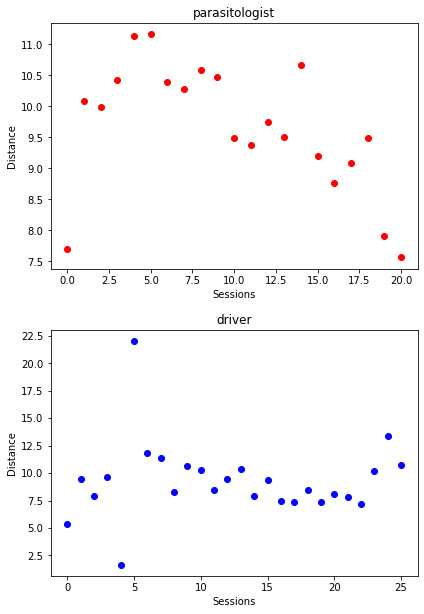

In [160]:
parasitologist_distance_means_by_session = mean_distances_for_man[20]
driver_distance_means_by_session = mean_distances_for_man[6]

matplotlib.pyplot.figure()

matplotlib.pyplot.subplot(211)
matplotlib.pyplot.xlabel('Sessions')
matplotlib.pyplot.ylabel('Distance')
matplotlib.pyplot.title(ppl_professions[20])
matplotlib.pyplot.plot(parasitologist_distance_means_by_session, 'ro')

matplotlib.pyplot.subplot(212)
matplotlib.pyplot.xlabel('Sessions')
matplotlib.pyplot.ylabel('Distance')
matplotlib.pyplot.title(ppl_professions[6])
matplotlib.pyplot.plot(driver_distance_means_by_session, 'bo')

matplotlib.pyplot.subplots_adjust(top=2.0, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

matplotlib.pyplot.show()

Let me plot a graph of people by their average bond during the time in Antarctica:

Let me create a wieghted graph of relations, one for each session:

In [145]:
session_graps = {x: networkx.MultiGraph() for x in sorted_filenames.keys()}

What groups did people created, if any?
 -> networkx.algorithms.clique.find_cliques

How changed the graps centrality over the sessions?